In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd

import sys
sys.path.append('D:/thesis/src')
from two_level_clustering.Utils import RectangularLattice
from two_level_clustering.SOCEM import SOCEM
from two_level_clustering.PbSOMClustering import PbSOMClustering
from two_level_clustering.Merging import Merging

from sklearn import metrics
mpl.rcParams['figure.dpi'] = 300

### Using real data to benchmark clustering

In [3]:
np.random.seed(42)
# Numbers of epochs for testing
epochs = 50

In [ ]:
def model_info(model_labels, true_labels):
    # Function that shows crosstab of cluster and actual labels

    df = pd.DataFrame({'clust_label': model_labels, 'orig_label': true_labels})
    ct = pd.crosstab(df['clust_label'], df['orig_label'])
    display(ct)


def clustering_quality(y_true, y_pred):
    ari = metrics.adjusted_rand_score(y_true, y_pred)
    nmi = metrics.normalized_mutual_info_score(y_true, y_pred)
    ami = metrics.adjusted_mutual_info_score(y_true, y_pred)
    v_measure = metrics.v_measure_score(y_true, y_pred)
    fm_score = metrics.fowlkes_mallows_score(y_true, y_pred)
    
    print("Adjusted Rand Index:", ari)
    print("Normalized Mutual Information:", nmi)
    print("Adjusted Mutual Information:", ami)
    print("V-Measure:", v_measure)
    print("Fowlkes-Mallows Score:", fm_score)
    
    return ari, nmi, ami, v_measure, fm_score

In [4]:
df = pd.read_csv("..//data/GvHD_pos_clustered.csv") 

In [5]:
df

,CD4,CD8b,CD3,CD8,cluster_label
0,308,220,157,339,3
1,319,271,223,350,3
2,215,148,119,221,3
3,104,49,284,178,8
4,262,167,144,156,3
...,...,...,...,...,...
9078,121,53,51,180,2
9079,194,182,203,199,3
9080,201,183,115,227,3
9081,241,213,166,212,3


In [6]:
labels = df['cluster_label']
df = df.loc[:, ['CD4', 'CD8b', 'CD3', 'CD8']]

In [7]:
X = df.to_numpy()

In [8]:
X

array([[308, 220, 157, 339],
       [319, 271, 223, 350],
       [215, 148, 119, 221],
       ...,
       [201, 183, 115, 227],
       [241, 213, 166, 212],
       [223, 184,  69, 279]], dtype=int64)

In [9]:
class Algorithm1:
    '''PbSOM + MML + Combining'''

    def __init__(self, lattice, sigma_start, sigma_step, betta, cov_type, tol, max_iter, reg_covar, merge_method, merge_threshold):
        self.lattice = lattice
        self.sigma_start = sigma_start
        self.sigma_step = sigma_step
        self.betta = betta
        self.cov_type = cov_type
        self.tol = tol
        self.max_iter = max_iter
        self.reg_covar = reg_covar
        self.merge_method = merge_method
        self.merge_threshold = merge_threshold

        self.labels_ = None
    
    def fit(self, X):
        pbsom = SOCEM(self.lattice, self.sigma_start, self.sigma_step, self.betta, self.cov_type, self.tol, self.max_iter, reg_covar=self.reg_covar)
        pbsom.fit(X)

        em_reduction = PbSOMClustering(pbsom)
        em_reduction.fit(X)

        weights, means, covs = em_reduction.get_params()
        merging = Merging(weights, means, covs, self.merge_method, self.merge_threshold)
        merging.fit(X)

        self.labels_ = merging.labels_

In [10]:
# k*k - max number of clusters
k = 6

### Entropy

In [11]:
statistics = []

for i in range(epochs):
    lattice = RectangularLattice((k, k))

    algorithm1_entropy = Algorithm1(lattice, sigma_start = 0.9, sigma_step = 0.02, max_iter=100, tol=1e-5, 
                        betta=0.2, cov_type='spherical', reg_covar=1e-4, merge_method='entropy', merge_threshold=None)

    algorithm1_entropy.fit(X)
    statistics.append([clustering_quality(labels, algorithm1_entropy.labels_)])

    print("Epoch {} done".format(i))

Adjusted Rand Index: 0.7900732701825808
Normalized Mutual Information: 0.8089652939725792
Adjusted Mutual Information: 0.808270898576247
V-Measure: 0.8089652939725791
Fowlkes-Mallows Score: 0.874023344021666
Epoch 0 done
Adjusted Rand Index: 0.8782932229528901
Normalized Mutual Information: 0.8625034537791452
Adjusted Mutual Information: 0.8621732250565016
V-Measure: 0.8625034537791452
Fowlkes-Mallows Score: 0.925063513505237
Epoch 1 done
Adjusted Rand Index: 0.9403614572349138
Normalized Mutual Information: 0.8921631854606314
Adjusted Mutual Information: 0.8918551221920202
V-Measure: 0.8921631854606313
Fowlkes-Mallows Score: 0.9618943718466494
Epoch 2 done
Adjusted Rand Index: 0.9352231642809974
Normalized Mutual Information: 0.8885654287805178
Adjusted Mutual Information: 0.8882485136874341
V-Measure: 0.8885654287805177
Fowlkes-Mallows Score: 0.9585600893508589
Epoch 3 done
Adjusted Rand Index: 0.9060675432740045
Normalized Mutual Information: 0.8548880964112575
Adjusted Mutual Infor

In [12]:
entropy_statistics = np.array(statistics)
entropy_statistics = entropy_statistics.transpose(2, 1, 0).squeeze()

In [13]:
entropy_statistics[0]

array([0.79007327, 0.87829322, 0.94036146, 0.93522316, 0.90606754,
       0.93522316, 0.60151114, 0.87829322, 0.9256952 , 0.79082878,
       0.9256952 , 0.93549026, 0.88973865, 0.90606754, 0.93522316,
       0.87829322, 0.93549026, 0.90606754, 0.79082878, 0.94036146,
       0.79007327, 0.93591781, 0.9256952 , 0.79007327, 0.79007327,
       0.80070651, 0.79007327, 0.94036146, 0.94036146, 0.9256952 ,
       0.94515063, 0.9256952 , 0.93549026, 0.87829322, 0.90606754,
       0.60151114, 0.94515063, 0.90606754, 0.88973865, 0.79501273,
       0.93650727, 0.79007327, 0.94515063, 0.79082878, 0.87829322,
       0.93591781, 0.9256952 , 0.94036146, 0.87829322, 0.60151114])

In [14]:
np.mean(entropy_statistics[0])

0.8720933300412527

### Ridgeline

In [15]:
statistics = []

for i in range(epochs):
    lattice = RectangularLattice((k, k))

    algorithm1_ridgeline = Algorithm1(lattice, sigma_start = 0.8, sigma_step = 0.02, max_iter=100, tol=1e-5, 
                        betta=0.2, cov_type='spherical', reg_covar=1e-4, merge_method='ridgeline', merge_threshold=0.9)

    algorithm1_ridgeline.fit(X)
    statistics.append([clustering_quality(labels, algorithm1_ridgeline.labels_)])

    print("Epoch {} done".format(i))

Adjusted Rand Index: 0.5122991047901062
Normalized Mutual Information: 0.7018808996868597
Adjusted Mutual Information: 0.7013470554444985
V-Measure: 0.7018808996868596
Fowlkes-Mallows Score: 0.6801031630687852
Epoch 0 done
Adjusted Rand Index: 0.5122991047901062
Normalized Mutual Information: 0.7018808996868597
Adjusted Mutual Information: 0.7013470554444985
V-Measure: 0.7018808996868596
Fowlkes-Mallows Score: 0.6801031630687852
Epoch 1 done
Adjusted Rand Index: 0.6286580043467745
Normalized Mutual Information: 0.7423841472269616
Adjusted Mutual Information: 0.7417610799991374
V-Measure: 0.7423841472269616
Fowlkes-Mallows Score: 0.7678885174082286
Epoch 2 done
Adjusted Rand Index: 0.5814220790514636
Normalized Mutual Information: 0.7660196949804695
Adjusted Mutual Information: 0.7655229056438223
V-Measure: 0.7660196949804695
Fowlkes-Mallows Score: 0.7396222052052577
Epoch 3 done
Adjusted Rand Index: 0.6393040762960341
Normalized Mutual Information: 0.7380902155239281
Adjusted Mutual In

In [16]:
ridgeline_statistics = np.array(statistics)
ridgeline_statistics = ridgeline_statistics.transpose(2, 1, 0).squeeze()

In [17]:
ridgeline_statistics[0]

array([0.5122991 , 0.5122991 , 0.628658  , 0.58142208, 0.63930408,
       0.51084552, 0.63717053, 0.62780467, 0.50318152, 0.63974609,
       0.628658  , 0.75662156, 0.63974609, 0.54458608, 0.63974609,
       0.50118455, 0.58142208, 0.63637865, 0.63717053, 0.50118455,
       0.63974609, 0.50118455, 0.63637865, 0.5122991 , 0.628658  ,
       0.6350062 , 0.63974609, 0.62780467, 0.51222622, 0.51222622,
       0.628658  , 0.6350062 , 0.59699236, 0.6350062 , 0.50118455,
       0.5122991 , 0.58142208, 0.63717053, 0.63637865, 0.5122991 ,
       0.6350062 , 0.6350062 , 0.63930408, 0.63974609, 0.58142208,
       0.58142208, 0.50559238, 0.5122991 , 0.63637865, 0.63930408])

### Comparison

In [18]:
plt.style.use('seaborn-v0_8-muted')

In [19]:
statistics = np.array([entropy_statistics[0], ridgeline_statistics[0]])

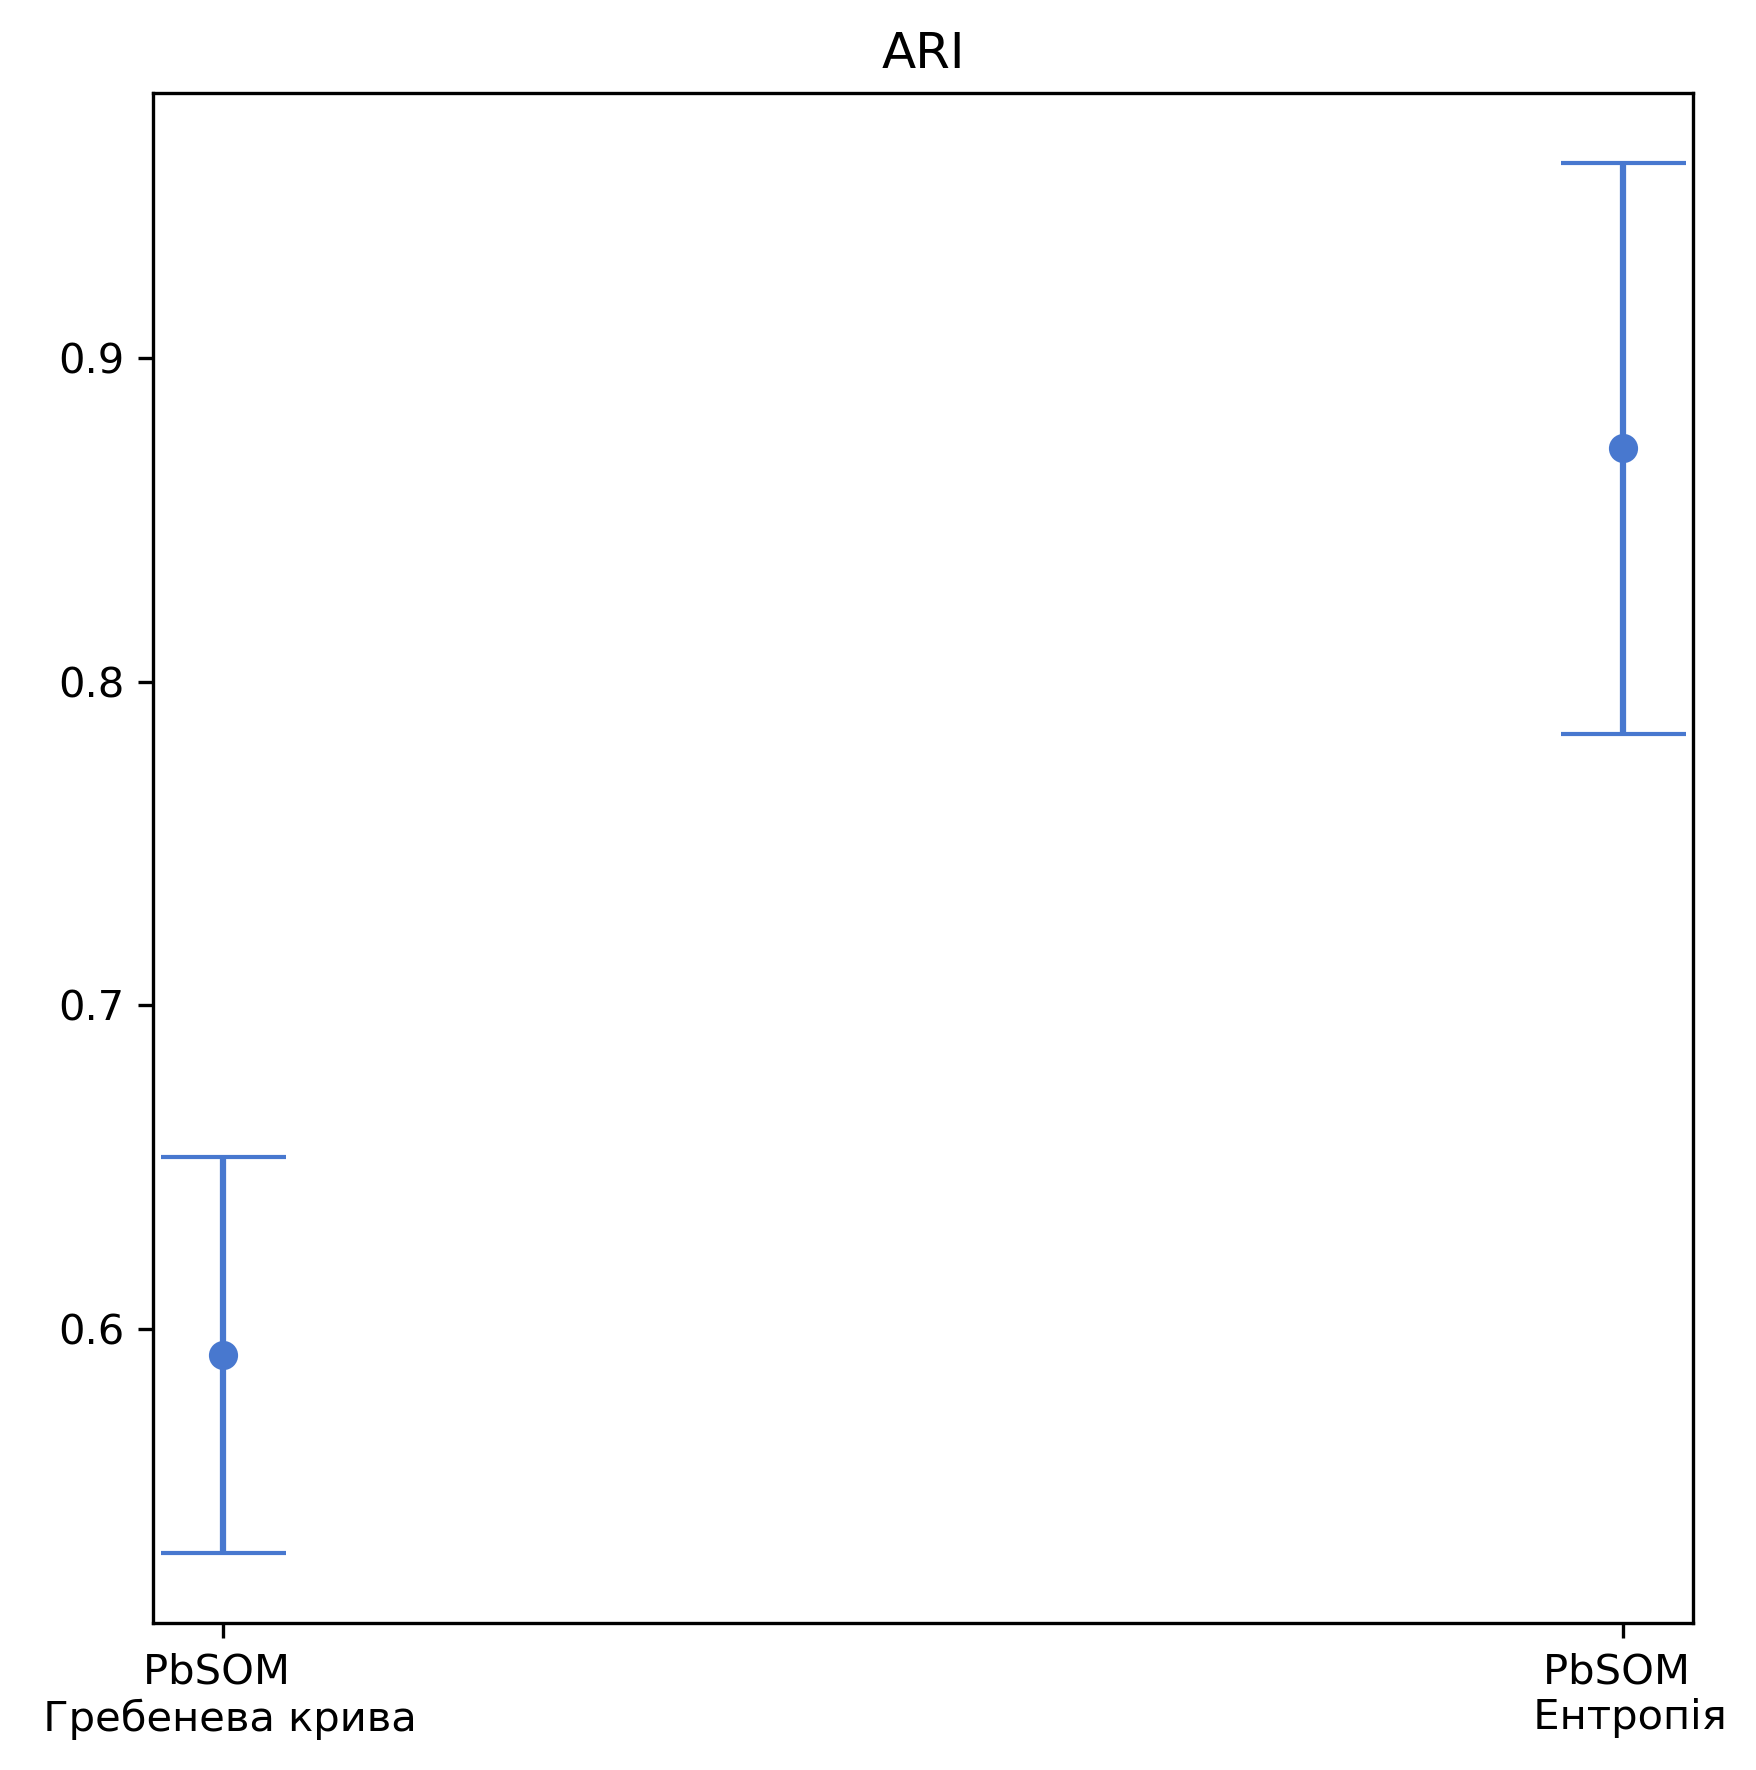

In [20]:
values_flat = statistics.flatten()
group_labels = np.repeat(['PbSOM \n Ентропія', 'PbSOM \n Гребенева крива'], statistics.shape[1])

# Calculate mean and standard deviation for each group
group_means = [np.mean(values_flat[group_labels == label]) for label in np.unique(group_labels)]
group_std = [np.std(values_flat[group_labels == label]) for label in np.unique(group_labels)]

# Create the error bar plot
fig, ax = plt.subplots(figsize=(6, 6))
ax.errorbar(np.unique(group_labels), group_means, yerr=group_std, fmt='o', capsize=15)
ax.set_title("ARI")
plt.tight_layout()
plt.savefig('../Images/real_data_res.png', dpi=300)